**12장 – 텐서플로를 사용한 사용자 정의 모델과 훈련**

_이 노트북은 12장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/12_custom_models_and_training_with_tensorflow.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [8]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


#12 텐서플로를 이용한 사용자 정의 모델과 훈련

##12.1 텐서플로 훑어보기

###텐서플로는 어떤것을 지원할까?
- 넘파이와 비슷하지만, __그래픽카드를 지원__한다.
- __분산 컴퓨팅__을 지원한다
- 속도를 높이고 메모리 사용량을 줄이기 위해 계산을 최적화 하는 __JIT 컴파일러__를 포함한다.
- 플랫폼에 크게 얽매이지 않는다.
- __자동 미분 기능__과 __고성능 옵티마이저__들을 제공한다.

<br>저수준의 텐서플로 연산은 매우 효율적인 c++ 코드로 구현되어있다.
<br>대부분의 구현은 __커널__ 이라고 부르는 여러가지 구현을 가지고 있으며, 이를 통해 __CPU, GPU, TPU__ 와 같은기기에 따라 맞는 구현 방식을 사용한다.
<br>
###텐서플로와 관계된 다른 생태계는 어떤것이 존재할까?
- 텐서보드:
- TFX: 텐서플로 제품화를 위한 __라이브러리 모음집__
- 텐서플로 허브: __사전 훈련된 신경망__을 손쉽게 사용할 수 있도록 만든 __프로젝트 저장소__

##12.2 넘파이처럼 텐서플로 사용하기

텐서플로는 __텐서를 순환시키는 형태로 연산__해서 붙은 이름이다.
<br>또한 넘파이의 ndarray와 매우 비슷한 __다차원 배열__이지만 스칼라 값도 가질 수 있다. 

텐서는 사용자 정의 기능을 만들 떄 매우 중요하므로, 조작하는 방법에 대해 알 필요가 있다.

###12.2.1 텐서와 연산
tf.constant()함수로 텐서를 만들 수 있으며,
<br>행렬을 매개변수로 줄 경우 __행렬 형태__의 텐서
<br>숫자만 매개변수로 줄 경우 __스칼라 형태__의 텐서가 생성된다.

또한, ndarray와 마찬가지로 tf.Tensor는 __크기와 자료형__을 가진다.

### 텐서

In [9]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # 행렬 형태

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [10]:
tf.constant(42) # 스칼라 형태

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [11]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [12]:
t.shape # 행렬의 크기 구하기

TensorShape([2, 3])

In [13]:
t.dtype # 텐서의 자료형 구하기

tf.float32

ndarray와 인덱스 참조가 __비슷하게 작동__하면서도, __모든 종류의 텐서 연산이 가능__한 것이 특징이다.

In [14]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [15]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [16]:
t + 10
# t+10 = tf.sum(t, 10)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [17]:
tf.square(t)
#각 원소들을 제곱함

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [18]:
t @ tf.transpose(t)
#@는 행렬곱과 같음, t @ tf.transpose(t) == tf.matmul(t, tf.transpose(t))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### `keras.backend` 사용하기

In [19]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

##12.2.2 텐서와 넘파이
위에서 텐서가 넘파이와 비슷하다고 한 만큼 __함께 사용하기도 편리__하다.
- __넘파이 배열로 텐서__를 만들 수 있고, __그 반대도 가능__하다.
- 넘파이, 텐서 배열에 __각자의 연산을 적용__시킬 수도 있다.

In [20]:
a = np.array([2., 4., 5.])
tf.constant(a)
#넘파이 배열로 텐서를 만들 수 있다.

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [21]:
t.numpy()
#텐서로 넘파이 배열을 만들 수 있다.

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [22]:
np.array(t)
#t.numpy() = np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [23]:
tf.square(a)
#각자의 연산을 적용할 수 있음을 보이고 있다.

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [24]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

##12.2.3 타입 변환
타입변환은 __성능을 감소시키는 요인중 하나__로,
<br>자동적으로 진행될 경우 __사용자가 알아채기 힘들기 때문__에 텐서플로에선 타입변환이 __자동적으로 수행되지 않는다__.

타입변환이 필요하다면 tf.cast() 함수를 사용하면 된다.

In [25]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)
  #두 텐서의 자료형이 달라 예외가 발생하는 모습이다.

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [26]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


In [27]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)
#tf.case() 함수를 사용하면 정상적으로 계산을 진행할 수 있다.

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### 문자열

In [28]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [29]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [30]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [31]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [32]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

### 문자열 배열

In [33]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [34]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [35]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>

In [36]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>


### 래그드 텐서

In [37]:
print(r[1])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)


In [38]:
print(r[1:3])

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [39]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>


In [40]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71],
 [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [41]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

In [42]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]], dtype=int32)>

### 희소 텐서

In [43]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [44]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [45]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [46]:
s2 = s * 2.0

In [47]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [48]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [49]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [50]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] is out of order. Many sparse ops require sorted indices.
  Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [51]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### 집합

In [52]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]], dtype=int32)>

In [53]:
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]], dtype=int32)>

In [54]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]], dtype=int32)>

##12.2.4 변수
지금까지 만들어온 tf.Tensor는 __변경이 불가능한 상수 객체__이다.
상수객체만 사용하면 __가중치 구현이 불가능__하기 때문에, 변경이 가능한 객체가 필요한데 이를 __tf.Variable__로 만들 수 있다.

tf.Variable은 tf.Tensor와 __매우 비슷하게 동작__하지만 assign()메소드를 통해 __변숫값을 변경__할 수 있다.

각 원소들에 대한 변경은 메소드 __assign(), scatter_update(), scatter_nd_update()__ 등을 사용해 수행할 수 있다.

In [55]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

In [56]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [57]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [58]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [59]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [60]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [61]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

### 텐서 배열

In [62]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [63]:
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [64]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [65]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [66]:
variance

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

## 12.2.1 사용자 정의 손실 함수

케라스에서 기본적으로 제공하는 함수 대신 다른 함수를 사용한다면 사용자가 직접 정의하여 사용할 수 있다.
<br>이번 예시에 해당하는 함수는 __휴버 손실 함수__이다.



캘리포니아 주택 데이터셋을 로드하여 준비해 보겠습니다. 먼저 이 데이터셋을 로드한 다음 훈련 세트, 검증 세트, 테스트 세트로 나눕니다. 마지막으로 스케일을 변경합니다:

In [67]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [68]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

    #1보다 오차가 작으면 작은 오차라고 취급한다.

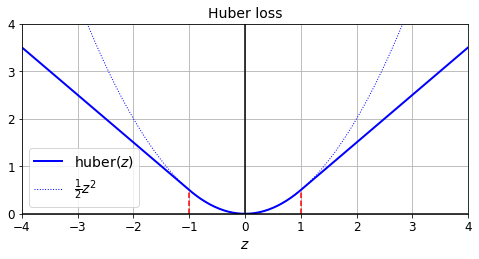

In [69]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [70]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [71]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [72]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.6235 - mae: 0.9953 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2197 - mae: 0.5177 - val_loss: 0.2382 - val_mae: 0.5281


##12.3.2 사용자 정의 요소를 가진 모델을 저장하고 로드하기

케라스가 함수 이름을 저장하기 떄문에 사용자 정의 손실 함수를 사용하는 모델은 아무 이상 없이 저장할 수 있다.

기준값이 다른 휴버 손실 함수의 __기준값까지 저장__하기 위해선 휴버 손실 함수를 __클래스로 정의__해야한다.

In [73]:
model.save("my_model_with_a_custom_loss.h5")

In [74]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})
#모델을 로드할 땐 사용자 정의 객체 이름- 사용자 정의 객체 를 매핑한 딕셔너리를 전달해야한다

In [75]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2054 - mae: 0.4982 - val_loss: 0.2209 - val_mae: 0.5050
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1999 - mae: 0.4900 - val_loss: 0.2127 - val_mae: 0.4986


In [76]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn
    #기준값을 전달받는 함수

In [77]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [78]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2226 - mae: 0.4892 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2184 - mae: 0.4844 - val_loss: 0.2372 - val_mae: 0.4879


In [79]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [80]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})
# 기준값을 저장할 수 없어 전달해주어야한다.

In [81]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2147 - mae: 0.4800 - val_loss: 0.2133 - val_mae: 0.4654
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2119 - mae: 0.4762 - val_loss: 0.1992 - val_mae: 0.4643


In [82]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

# keras.losses.Loss 클래스를 상속한 뒤 get_config() 메소드를 구현하면 해결된다.

In [83]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [84]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [85]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.7095 - mae: 0.8863 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2416 - mae: 0.5083 - val_loss: 0.2660 - val_mae: 0.5089


In [86]:
model.save("my_model_with_a_custom_loss_class.h5")

In [87]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [88]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2286 - mae: 0.4970 - val_loss: 0.2120 - val_mae: 0.4723
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2216 - mae: 0.4904 - val_loss: 0.2045 - val_mae: 0.4725


In [89]:
model.loss.threshold

2.0

##12.3. 활성화 함수, 초기화, 규제, 제한을 커스터마이징 하기
손실, 규제, 제한, 초기화, 지표, 활성화 함수, 층 , 모델 등 케라스 대부분의 기능은 위의 휴버 손실 함수와 같은 방법으로 __저장할 수 있다.__

In [90]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [91]:
def my_softplus(z): # tf.nn.softplus(z) 값을 반환합니다
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # tf.nn.relu(weights) 값을 반환합니다
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [92]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [93]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [94]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [95]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [96]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [97]:
model.save("my_model_with_many_custom_parts.h5")

In [98]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

함수가 모델과 함께 저장해야할 파라미터가 있다면 알맞은 __부모클래스를 상속하여 구현__하면 된다.

In [99]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}
    #위 사용자정의 regulizer를 keras.regulizers.Regularizer를 상속해 정의한 못습/

In [100]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [101]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])
#사용자 정의 함수는 제공되는 함수와 같은 방식으로 사용할 수 있다.

In [102]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [103]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [104]:
model.save("my_model_with_many_custom_parts.h5")

In [105]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

#사용자 정의 객체들은 그 이름과 매핑된 딕셔너리를 통해 불러와야한다.

## 12.3.4 사용자 정의 지표

In [106]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [107]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [108]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [109]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 2.0982 - huber_fn: 0.9192
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.6052 - huber_fn: 0.2733


**노트**: 손실과 지표에 같은 함수를 사용하면 다른 결과가 나올 수 있습니다. 이는 일반적으로 __부동 소수점 정밀도 오차__ 때문입니다. 수학 식이 동일하더라도 연산은 동일한 순서대로 실행되지 않습니다. 이로 인해 작은 차이가 발생합니다. 또한 샘플 가중치를 사용하면 정밀도보다 더 큰 오차가 생깁니다:

* 에포크에서 손실은 지금까지 본 모든 배치 손실의 평균입니다. 각 배치 손실은 가중치가 적용된 샘플 손실의 합을 _배치 크기_ 로 나눈 것입니다(샘플 가중치의 합으로 나눈 것이 아닙니다. 따라서 배치 손실은 손실의 가중 평균이 아닙니다).
* 에포크에서 지표는 가중치가 적용된 샘플 손실의 합을 지금까지 본 모든 샘플 가중치의 합으로 나눈 것입니다. 다른 말로하면 모든 샘플 손실의 가중 평균입니다. 따라서 위와 같지 않습니다.

수학적으로 말하면 손실 = 지표 * 샘플 가중치의 평균(더하기 약간의 부동 소수점 정밀도 오차)입니다.

In [110]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [111]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.1175 - huber_fn: 0.2399
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1131 - huber_fn: 0.2297


In [112]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11749907582998276, 0.11906625573138947)

### 스트리밍 지표

스트리밍 지표를 사용자 정의로 만들고 싶다면 keras.metrics.Metric을 상속한다.

In [113]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [114]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [115]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [116]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [117]:
precision.reset_states()

스트리밍 지표 만들기:

In [118]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # 기본 매개변수 처리 (예를 들면, dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [119]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [120]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [121]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [122]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

`HuberMetric` 클래스가 잘 동작하는지 확인해 보죠:

In [123]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [124]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [125]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [126]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.8707 - huber_metric: 0.8707
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2595 - huber_metric: 0.2595


In [127]:
model.save("my_model_with_a_custom_metric.h5")

In [128]:
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [129]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2350 - huber_metric: 0.2350
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2278 - huber_metric: 0.2278


**경고**: 텐서플로 2.2에서 tf.keras가 `model.metrics`의 0번째 위치에 지표를 추가합니다([텐서플로 이슈 #38150](https://github.com/tensorflow/tensorflow/issues/38150) 참조). 따라서 `HuberMetric`에 접근하려면 `model.metrics[0]` 대신 `model.metrics[-1]`를 사용해야 합니다.

In [130]:
model.metrics[-1].threshold

2.0

잘 동작하는군요! 다음처럼 더 간단하게 클래스를 만들 수 있습니다:

In [131]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

이 클래스는 크기를 잘 처리하고 샘플 가중치도 지원합니다.

In [132]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [133]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [134]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [135]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.4455 - HuberMetric: 0.8978
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1305 - HuberMetric: 0.2631


In [136]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.44554364681243896, 0.44554368685750223)

In [137]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [138]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})

In [139]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2377 - HuberMetric: 0.2377
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2279 - HuberMetric: 0.2279


In [140]:
model.metrics[-1].threshold

2.0

## 12.3.5사용자 정의 층
사용자 정의 층은 __가중치가 없는__경우와 __가중치가 있는__ 경우가 있다.

In [141]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))
#가중치가 없는 층을 가장 간단하게 만드는 방법은 keras.layers.Lambda로 감싸는 것이다.

In [142]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787948, 1.        , 2.7182817 ], dtype=float32)>

회귀 모델이 예측할 값이 양수이고 스케일이 매우 다른 경우 (예를 들어, 0.001, 10., 10000) 출력층에 지수 함수를 추가하면 유용할 수 있습니다:

In [143]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [144]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 3ms/step - loss: 1.0631 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4562 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4029 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.3851 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.3586


0.3586340844631195

In [145]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

    #가중치가 있는 층은 이전처럼 keras.layers.Layer를 상솟하여 구현한다.

In [146]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [147]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [148]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 2.2563 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.5474


0.5473727583885193

In [149]:
model.save("my_model_with_a_custom_layer.h5")

In [150]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [151]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # 사용자 정의 층 디버깅
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

사용자 정의 층은 다음처럼 함수형 API를 사용해 호출할 수 있습니다:

In [152]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


`call()` 메서드는 심볼릭 입력을 받습니다. 이 입력의 크기는 부분적으로만 지정되어 있습니다(이 시점에서는 배치 크기를 모릅니다. 그래서 첫 번째 차원이 None입니다):

사용자 층에 실제 데이터를 전달할 수도 있습니다. 이를 테스트하기 위해 각 데이터셋의 입력을 각각 네 개의 특성을 가진 두 부분으로 나누겠습니다:

In [153]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

# 분할된 데이터 크기 출력
X_train_scaled_A.shape, X_train_scaled_B.shape

((11610, 4), (11610, 4))

크기가 완전하게 지정된 것을 볼 수 있습니다:

In [154]:
outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

X1.shape:  (11610, 4)  X2.shape:  (11610, 4)


함수형 API를 사용해 완전한 모델을 만들어 보겠습니다(이 모델은 간단한 예제이므로 놀라운 성능을 기대하지 마세요):

In [155]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation='selu')(hidden_A)
hidden_B = keras.layers.Dense(30, activation='selu')(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

X1.shape:  (None, 4)  X2.shape:  (None, 4)


In [156]:
model.compile(loss='mse', optimizer='nadam')

In [157]:
model.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=2,
          validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))

Epoch 1/2
X1.shape:  (None, 4)  X2.shape:  (None, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
363/363 [==============================] - 2s 4ms/step - loss: 2.1142 - val_loss: 1.3630
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.9684 - val_loss: 0.9773


훈련과 테스트에서 다르게 동작하는 층을 만들어 보죠:

In [158]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

다음은 사용자 정의 층을 사용하는 간단한 모델입니다:

In [159]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [160]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 2.3857 - val_loss: 7.6082
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.7560


0.7559615969657898

##12.3.6 사용자 정의 모델
10장에서 다룬 것 처럼 클래스를 사용하여 사용자 정의 모델을 만들 수 있다.

In [161]:
X_new_scaled = X_test_scaled

In [162]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [163]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

    #keras.models.Model 클래스를 상속하여 생성자에서 층을 만들어 구현한다.

In [164]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [165]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 3s 4ms/step - loss: 9.1325
Epoch 2/5
363/363 [==============================] - 2s 4ms/step - loss: 1.0578
Epoch 3/5
363/363 [==============================] - 2s 5ms/step - loss: 0.8869
Epoch 4/5
363/363 [==============================] - 2s 4ms/step - loss: 0.5831
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.6513


In [166]:
model.save("my_custom_model.ckpt")

In [167]:
model = keras.models.load_model("my_custom_model.ckpt")

In [168]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 3s 5ms/step - loss: 0.8017
Epoch 2/5
363/363 [==============================] - 2s 5ms/step - loss: 0.5028
Epoch 3/5
363/363 [==============================] - 2s 5ms/step - loss: 0.5362
Epoch 4/5
363/363 [==============================] - 2s 5ms/step - loss: 0.4120
Epoch 5/5
363/363 [==============================] - 2s 5ms/step - loss: 0.5718


대신 시퀀셜 API를 사용하는 모델을 정의할 수 있습니다:

In [169]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [170]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [171]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 3s 4ms/step - loss: 0.8695
Epoch 2/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4720
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.5537
Epoch 4/5
363/363 [==============================] - 1s 4ms/step - loss: 0.3809
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.4852


##12.3.7 모델 구성 요소에 기반한 손실과 지표

**노트**: 다음 코드는 책의 코드와 두 가지 다른 점이 있습니다:
1. 생성자에서 `keras.metrics.Mean()` 측정 지표를 만들고 `call()` 메서드에서 사용하여 평균 재구성 손실을 추적합니다. 훈련에서만 사용해야 하기 때문에 `call()` 메서드에 `training` 매개변수를 추가합니다. `training`이 `True`이면 `reconstruction_mean`를 업데이트하고 `self.add_metric()`를 호출합니다.
2. TF 2.2에 있는 이슈([#46858](https://github.com/tensorflow/tensorflow/issues/46858)) 때문에 `build()` 메서드 안에서 `super().build()`를 호출하면 안됩니다.

In [172]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        #super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        self.recon_loss = 0.05 * tf.reduce_mean(tf.square(reconstruction - inputs))
        
        if training:
           result = self.reconstruction_mean(recon_loss)
           self.add_metric(result)
        return self.out(Z)
    
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred, regularization_losses=[self.recon_loss])

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {m.name: m.result() for m in self.metrics}

In [173]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [174]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.7886 - reconstruction_error: 0.0000e+00
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.4134 - reconstruction_error: 0.0000e+00


##12.3.8 자동 미분을 사용하여 그레이디언트 계산하기

In [175]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [176]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [177]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [178]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [179]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [180]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [181]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [182]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [183]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [184]:
gradients

[None, None]

In [185]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [186]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [187]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [188]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [189]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [190]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [191]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [192]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])
#그라디언트가 역전파되지 않도록 막기 위해선 tf.stop.gradient함수를 사용한다.

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [193]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [194]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [195]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [196]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [197]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [198]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

##12.3.9 사용자 정의 훈련 반복

드물게 fit()이 마음에 들지 않을 때 사용자 정의 훈련을 사용할 수 있다.

In [199]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [200]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [201]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [202]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [203]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


A fancier version with a progress bar:

In [204]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [205]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [206]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [207]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [208]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [209]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [210]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 [==============================] - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - mean: 0.6440 - mean_absolute_error: 0.5222


In [211]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

# 12.4 텐서플로 함수
텐서플로 1의 그래프는 핵심적인 기능이었으나, 텐서플로2에선 아니므로, 간단하게 다루고 넘어간다.

In [212]:
def cube(x):
    return x ** 3

In [213]:
cube(2)

8

In [214]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [215]:
tf_cube = tf.function(cube)
tf_cube

In [216]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [217]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

### TF 함수와 콘크리트 함수

In [218]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [219]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [220]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### 함수 정의와 그래프

In [221]:
concrete_function.graph

In [222]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [223]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [224]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [225]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [226]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [227]:
concrete_function.function_def.signature

name: "__inference_cube_1131147"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### TF 함수가 계산 그래프를 추출하기 위해 파이썬 함수를 트레이싱하는 방법

In [228]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [229]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [230]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [231]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # New shape: trace!

print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(2, 2), dtype=float32)
print: Tensor("x:0", shape=(3, 2), dtype=float32)


특정 입력 시그니처를 지정하는 것도 가능합니다:

In [232]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("트레이싱", images)
    return images[:, ::2, ::2] # 행과 열의 절반을 버립니다

In [233]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [234]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # 함수 트레이싱
preprocessed_images = shrink(img_batch_2) # 동일한 콘크리트 함수 재사용

트레이싱 Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [235]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # 다른 타입이나 크기 거부
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7413678  0.62854624]
  [0.01738465 0.3431449 ]]

 [[0.51063764 0.3777541 ]
  [0.07321596 0.02137029]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).


### 오토그래프를 사용해 제어 흐름 나타내기

`range()`를  사용한 정적인 `for` 반복:

In [236]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [237]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [238]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

`tf.while_loop()`를 사용한 동적인 반복:

In [239]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [240]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [241]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

(오토그래프에 의한) `tf.range()`를 사용한 동적인 `for` 반복:

In [242]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [243]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### TF 함수에서 변수와 다른 자원 다루기

In [244]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [245]:
increment(counter)
increment(counter)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [246]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [247]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [248]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [249]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [250]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [251]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [252]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [253]:
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown('```python\n{}\n```'.format(code)))

In [254]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

## tf.keras와 TF 함수를 함께 사용하거나 사용하지 않기

기본적으로 tf.keras는 자동으로 사용자 정의 코드를 TF 함수로 변환하기 때문에 `tf.function()`을 사용할 필요가 없습니다:

In [255]:
# 사용자 손실 함수
def my_mse(y_true, y_pred):
    print("my_mse() 손실 트레이싱")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [256]:
# 사용자 지표 함수
def my_mae(y_true, y_pred):
    print("my_mae() 지표 트레이싱")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [257]:
# 사용자 정의 층
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("MyDense.call() 트레이싱")
        return self.activation(X @ self.kernel + self.biases)

In [258]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [259]:
# 사용자 정의 모델
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("MyModel.call() 트레이싱")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [260]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [261]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
352/363 [============================>.] - ETA: 0s - loss: 1.3487 - my_mae: 0.7988MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
363/363 [==============================] - 2s 4ms/step - loss: 1.3255 - my_mae: 0.7900 - val_loss: 0.5569 - val_my_mae: 0.4819
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.4164 - my_mae: 0.4639


[0.4163525104522705, 0.4639028012752533]

`dynamic=True`로 모델을 만들어 이 기능을 끌 수 있습니다(또는 모델의 생성자에서 `super().__init__(dynamic=True, **kwargs)`를 호출합니다):

In [262]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [263]:
model = MyModel(dynamic=True)

In [264]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

사용자 정의 코드는 반복마다 호출됩니다. 너무 많이 출력되는 것을 피하기 위해 작은 데이터셋으로 훈련, 검증, 평가해 보겠습니다:

In [265]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱


[5.507259368896484, 2.0566811561584473]

또는 모델을 컴파일할 때 `run_eagerly=True`를 지정합니다:

In [266]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [267]:
model = MyModel()

In [268]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [269]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱


[5.507259368896484, 2.0566811561584473]

## 사용자 정의 옵티마이저

사용자 정의 옵티마이저를 정의하는 것은 일반적이지 않습니다. 하지만 어쩔 수 없이 만들어야 하는 상황이라면 다음 예를 참고하세요:

In [270]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """super().__init__()를 호출하고 _set_hyper()를 사용해 하이퍼파라미터를 저장합니다"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # lr=learning_rate을 처리
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """모델 파라미터마다 연관된 옵티마이저 변수를 만듭니다.
        텐서플로는 이런 옵티마이저 변수를 '슬롯'이라고 부릅니다.
        모멘텀 옵티마이저에서는 모델 파라미터마다 하나의 모멘텀 슬롯이 필요합니다.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """슬롯을 업데이트하고 모델 파라미터에 대한 옵티마이저 스텝을 수행합니다.
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # 학습률 감쇠 처리
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [271]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [272]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 3.8128
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.4877
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.9162
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7587
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7050


# 연습문제

## 1. to 11.
부록 A 참조.

## 12. _층 정규화_ 를 수행하는 사용자 정의 층을 구현하세요.

_15장에서 순환 신경망을 사용할 때 이런 종류의 층을 사용합니다._

### a.
_문제: `build()` 메서드에서 두 개의 훈련 가능한 가중치 *α*와 *β*를 정의합니다. 두 가중치 모두 크기가 `input_shape[-1:]`이고 데이터 타입은 `tf.float32`입니다. *α*는 1로 초기화되고 *β*는 0으로 초기화되어야 합니다._

솔루션: 아래 참조.

### b.
_문제: `call()` 메서드는 샘플의 특성마다 평균 μ와 표준편차 σ를 계산해야 합니다. 이를 위해 전체 샘플의 평균 μ와 분산 σ<sup>2</sup>을 반환하는 `tf.nn.moments(inputs, axes=-1, keepdims=True)`을 사용할 수 있습니다(분산의 제곱근으로 표준편차를 계산합니다). 그다음 *α*⊗(*X* - μ)/(σ + ε) + *β*를 계산하여 반환합니다. 여기에서 ⊗는 원소별
곱셈(`*`)을 나타냅니다. ε은 안전을 위한 항입니다(0으로 나누어지는 것을 막기 위한 작은 상수. 예를 들면 0.001)._

In [273]:
class LayerNormalization(keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")
        super().build(batch_input_shape) # 반드시 끝에 와야 합니다

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

_ε_ 하이퍼파라미터(`eps`)는 필수가 아닙니다. 또한 `tf.sqrt(variance) + self.eps` 보다 `tf.sqrt(variance + self.eps)`를 계산하는 것이 좋습니다. sqrt(z)의 도함수는 z=0에서 정의되지 않기 때문에 분산 벡터의 한 원소가 0에 가까우면 훈련이 이리저리 널뜁니다. 제곱근 안에 _ε_를 넣으면 이런 현상을 방지할 수 있습니다.

### c.
_문제: 사용자 정의 층이 `keras.layers.LayerNormalization` 층과 동일한(또는 거의 동일한) 출력을 만드는지 확인하세요._

각 클래스의 객체를 만들고 데이터(예를 들면, 훈련 세트)를 적용해 보죠. 차이는 무시할 수 있는 수준입니다.

In [274]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = keras.layers.LayerNormalization()

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=3.894674e-08>

네 충분히 가깝네요. 조금 더 확실하게 알파와 베타를 완전히 랜덤하게 지정하고 다시 비교해 보죠:

In [275]:
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=1.7224725e-08>

여전히 무시할 수 있는 수준입니다! 사용자 정의 층이 잘 동작합니다.

## 13. 사용자 정의 훈련 반복을 사용해 패션 MNIST 데이터셋으로 모델을 훈련해보세요.

_패션 MNIST 데이터셋은 10장에서 소개했습니다._

### a.
_문제: 에포크, 반복, 평균 훈련 손실, (반복마다 업데이트되는) 에포크의 평균 정확도는 물론 에포크 끝에서 검증 손실과 정확도를 출력하세요._

In [276]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

4431872/4422102 [==============================] - 0s 0us/step


In [277]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [278]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [279]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [280]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()


All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

### b.
_문제: 상위 층과 하위 층에 학습률이 다른 옵티마이저를 따로 사용해보세요._

In [281]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [282]:
lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
])
upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax"),
])
model = keras.models.Sequential([
    lower_layers, upper_layers
])

In [283]:
lower_optimizer = keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = keras.optimizers.Nadam(learning_rate=1e-3)

In [284]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [285]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]